In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import sklearn as skl

# Data Loading

In [2]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("../data/training_bert_reduced.csv")
test_data = pd.read_csv("../data/validation_bert_reduced.csv")
validation_data = pd.read_csv("../data/test_bert_reduced.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("e_")]
LABEL_COLUMN = "label"

In [3]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [4]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [5]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# SVM

In [6]:
from sklearn import svm


svm_classifier = svm.SVC(max_iter=100)

# Grid Search Hyperparameter Optimization

In [7]:
svm_search_space={
    'C': [1],
    'kernel': ['rbf'], # poly - 'rbf', 'linear', 'sigmoid' 
    'degree': [1],  # 3
    'gamma': ['scale'], #'auto',  1, 0.1, 0.01, 0.001, 0.0001, 
    'coef0': [0.1], 
    'shrinking': [True], 
    'probability': [False], 
    'tol': [0.1],  
    'class_weight': [None], 
    'decision_function_shape': ['ovr'], # 'ovo'
}

#Train the model using the training sets
svm_classifier.fit(X_train, Y_train)

gridsearch_svm = gridSearchHPO(svm_classifier, svm_search_space)

c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [8]:
gridsearch_svm.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5, error_score='raise', estimator=SVC(max_iter=100), n_jobs=-1,
             param_grid={'C': [1], 'class_weight': [None], 'coef0': [0.1],
                         'decision_function_shape': ['ovr'], 'degree': [1],
                         'gamma': ['scale'], 'kernel': ['rbf'],
                         'probability': [False], 'shrinking': [True],
                         'tol': [0.1]},
             scoring='accuracy', verbose=3)

In [9]:
print("Best Score: {}".format(gridsearch_svm.best_score_))
print("Best params: {}".format(gridsearch_svm.best_params_))

Best Score: 0.3864375
Best params: {'C': 1, 'class_weight': None, 'coef0': 0.1, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False, 'shrinking': True, 'tol': 0.1}


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


(0.275, 0.11862745098039218)


c:\Users\Joaquin\miniconda3\envs\agienv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


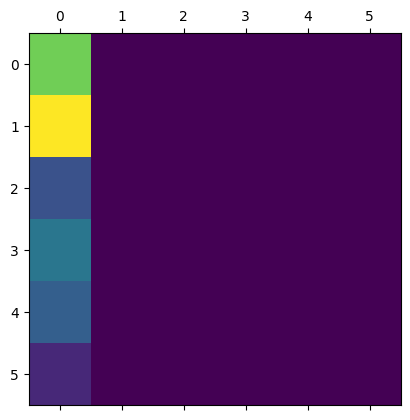

In [10]:
print(get_metrics(gridsearch_svm, X_test_used, Y_test))
c = get_cmat(gridsearch_svm, X_test_used, Y_test)
plt.matshow(c)
plt.show()